# **Loading Libraries and Dataset Exploration**

In [ ]:
#IMPORT IMPORTANT LIBRARIES
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth, association_rules
import time
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
# Load the dataset
file_path = "Accidental_Drug_Related_Deaths.csv"  # Define the file path
data = pd.read_csv(file_path)                     # Read the dataset into a DataFrame

In [ ]:
# Display basic dataset information
print("Dataset Info:")
print(data.info())                          # Print dataset structure and column data types

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11981 entries, 0 to 11980
Data columns (total 48 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           11981 non-null  object 
 1   Date Type                      11981 non-null  object 
 2   Age                            11979 non-null  float64
 3   Sex                            11972 non-null  object 
 4   Race                           11924 non-null  object 
 5   Ethnicity                      2565 non-null   object 
 6   Residence City                 11385 non-null  object 
 7   Residence County               10721 non-null  object 
 8   Residence State                9993 non-null   object 
 9   Injury City                    11803 non-null  object 
 10  Injury County                  8647 non-null   object 
 11  Injury State                   8952 non-null   object 
 12  Injury Place                   1

In [ ]:
# Display the first few rows of the dataset
print("\nSample Data:")
print(data.head())


Sample Data:
         Date      Date Type   Age     Sex   Race Ethnicity Residence City  \
0  05/29/2012  Date of death  37.0    Male  Black       NaN       STAMFORD   
1  06/27/2012  Date of death  37.0    Male  White       NaN        NORWICH   
2  03/24/2014  Date of death  28.0    Male  White       NaN         HEBRON   
3  12/31/2014  Date of death  26.0  Female  White       NaN         BALTIC   
4  01/16/2016  Date of death  41.0    Male  White       NaN        SHELTON   

  Residence County Residence State Injury City  ... Xylazine Gabapentin  \
0        FAIRFIELD             NaN    STAMFORD  ...      NaN        NaN   
1       NEW LONDON             NaN     NORWICH  ...      NaN        NaN   
2              NaN             NaN      HEBRON  ...      NaN        NaN   
3              NaN             NaN         NaN  ...      NaN        NaN   
4        FAIRFIELD              CT     SHELTON  ...      NaN        NaN   

  Opiate NOS Heroin/Morph/Codeine Other Opioid Any Opioid Other  \

# **Dataset Preprocessing for Association Analysis**

In [ ]:
# Creating a copy of the dataset to avoid modifying the original
ddeath = data.copy()

In [ ]:
# List of drug-related columns for analysis
drug_columns = [
    "Heroin", "Cocaine", "Fentanyl", "Fentanyl Analogue",
    "Oxycodone", "Oxymorphone", "Ethanol", "Hydrocodone", "Benzodiazepine", "Methadone",
    "Meth/Amphetamine", "Amphet", "Tramad", "Hydromorphone", "Morphine (Not Heroin)",
    "Xylazine", "Gabapentin"
]

# Convert categorical values 'Y' to 1 and NaN to 0
for col in drug_columns:
    if col in ddeath.columns:
        ddeath[col] = ddeath[col].apply(lambda x: 1 if x == 'Y' else 0)


# Display processed data sample
print("\nProcessed Data Sample:")
print(ddeath[drug_columns].head())


Processed Data Sample:
   Heroin  Cocaine  Fentanyl  Fentanyl Analogue  Oxycodone  Oxymorphone  \
0       0        1         0                  0          0            0   
1       1        0         0                  0          0            0   
2       1        0         0                  0          0            0   
3       1        0         0                  0          0            0   
4       0        0         1                  0          0            0   

   Ethanol  Hydrocodone  Benzodiazepine  Methadone  Meth/Amphetamine  Amphet  \
0        0            0               0          0                 0       0   
1        0            0               0          0                 0       0   
2        0            0               0          0                 0       0   
3        0            0               0          0                 0       0   
4        0            0               0          0                 0       0   

   Tramad  Hydromorphone  Morphine (Not Hero

In [ ]:
# Drop irrelevant columns that are not useful for association analysis
columns_to_drop = [
    "Date", "Date Type", "Age", "Sex", "Race", "Ethnicity",
    "Residence City", "Residence County", "Residence State",
    "Injury City", "Injury County", "Injury State", "Injury Place",
    "Description of Injury", "Death City", "Death County", "Death State",
    "Location", "Location if Other", "Cause of Death", "Manner of Death","Opiate NOS", "Other", 'Other Opioid',"Any Opioid","Heroin/Morph/Codeine",
    "Heroin death certificate (DC)", "Other Significant Conditions ", "ResidenceCityGeo", "InjuryCityGeo", "DeathCityGeo"
]

# Remove the columns if they exist in the dataset
ddeath.drop(columns=[col for col in columns_to_drop if col in ddeath.columns], inplace=True)

# Display the updated dataset structure
print("\nUpdated Dataset Columns:")
print(ddeath.columns)
ddeath.head()


Updated Dataset Columns:
Index(['Heroin', 'Cocaine', 'Fentanyl', 'Fentanyl Analogue', 'Oxycodone',
       'Oxymorphone', 'Ethanol', 'Hydrocodone', 'Benzodiazepine', 'Methadone',
       'Meth/Amphetamine', 'Amphet', 'Tramad', 'Hydromorphone',
       'Morphine (Not Heroin)', 'Xylazine', 'Gabapentin'],
      dtype='object')


,Heroin,Cocaine,Fentanyl,Fentanyl Analogue,Oxycodone,Oxymorphone,Ethanol,Hydrocodone,Benzodiazepine,Methadone,Meth/Amphetamine,Amphet,Tramad,Hydromorphone,Morphine (Not Heroin),Xylazine,Gabapentin
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Convert dataset rows into a list of transactions for association rule mining
transactions = ddeath.apply(lambda row: [col for col in drug_columns if row[col] == 1], axis=1)
transactions = transactions.tolist()

# Use TransactionEncoder to convert the transactions into a structured format
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# Display the transformed dataset
print("\nTransaction Data Sample:")
print(df_encoded.head())


Transaction Data Sample:
   Amphet  Benzodiazepine  Cocaine  Ethanol  Fentanyl  Fentanyl Analogue  \
0   False           False     True    False     False              False   
1   False           False    False    False     False              False   
2   False           False    False    False     False              False   
3   False           False    False    False     False              False   
4   False           False    False    False      True              False   

   Gabapentin  Heroin  Hydrocodone  Hydromorphone  Meth/Amphetamine  \
0       False   False        False          False             False   
1       False    True        False          False             False   
2       False    True        False          False             False   
3       False    True        False          False             False   
4       False   False        False          False             False   

   Methadone  Morphine (Not Heroin)  Oxycodone  Oxymorphone  Tramad  Xylazine  
0      Fal

# **Apriori Algorithm**

In [ ]:
# Apply Apriori algorithm for frequent itemset mining
min_support = 0.05  # Minimum support threshold
frequent_itemsets_apriori = apriori(df_encoded, min_support=min_support, use_colnames=True)

# Display frequent itemsets from Apriori
print("\nFrequent Itemsets from Apriori:")
print(frequent_itemsets_apriori)

# Generate association rules from Apriori results
min_confidence = 0.6  # Minimum confidence threshold
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=min_confidence)

# Display association rules from Apriori
print("\nAssociation Rules from Apriori:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Frequent Itemsets from Apriori:
     support                       itemsets
0   0.226776               (Benzodiazepine)
1   0.382105                      (Cocaine)
2   0.267090                      (Ethanol)
3   0.671647                     (Fentanyl)
4   0.081295            (Fentanyl Analogue)
5   0.298640                       (Heroin)
6   0.089976                    (Methadone)
7   0.084801                    (Oxycodone)
8   0.089976                     (Xylazine)
9   0.056339      (Cocaine, Benzodiazepine)
10  0.055338      (Ethanol, Benzodiazepine)
11  0.133461     (Fentanyl, Benzodiazepine)
12  0.068442       (Heroin, Benzodiazepine)
13  0.095318             (Cocaine, Ethanol)
14  0.277272            (Cocaine, Fentanyl)
15  0.095401              (Cocaine, Heroin)
16  0.181454            (Fentanyl, Ethanol)
17  0.074368              (Heroin, Ethanol)
18  0.080294  (Fentanyl Analogue, Fentanyl)
19  0.168600             (Heroin, Fentanyl)
20  0.089642           (Fentanyl, Xylazine)

# **FP Algorithm**

In [ ]:
# Apply FP-Growth algorithm for frequent itemset mining
frequent_itemsets_fpgrowth = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)

# Display frequent itemsets from FP-Growth
print("\nFrequent Itemsets from FP-Growth:")
print(frequent_itemsets_fpgrowth)

# Generate association rules from FP-Growth results
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=min_confidence)

# Display association rules from FP-Growth
print("\nAssociation Rules from FP-Growth:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


Frequent Itemsets from FP-Growth:
     support                       itemsets
0   0.382105                      (Cocaine)
1   0.298640                       (Heroin)
2   0.671647                     (Fentanyl)
3   0.084801                    (Oxycodone)
4   0.267090                      (Ethanol)
5   0.089976                     (Xylazine)
6   0.226776               (Benzodiazepine)
7   0.089976                    (Methadone)
8   0.081295            (Fentanyl Analogue)
9   0.277272            (Cocaine, Fentanyl)
10  0.095401              (Cocaine, Heroin)
11  0.168600             (Heroin, Fentanyl)
12  0.058676    (Cocaine, Heroin, Fentanyl)
13  0.074368              (Heroin, Ethanol)
14  0.181454            (Fentanyl, Ethanol)
15  0.095318             (Cocaine, Ethanol)
16  0.072949   (Cocaine, Fentanyl, Ethanol)
17  0.089642           (Fentanyl, Xylazine)
18  0.133461     (Fentanyl, Benzodiazepine)
19  0.068442       (Heroin, Benzodiazepine)
20  0.055338      (Ethanol, Benzodiazepin

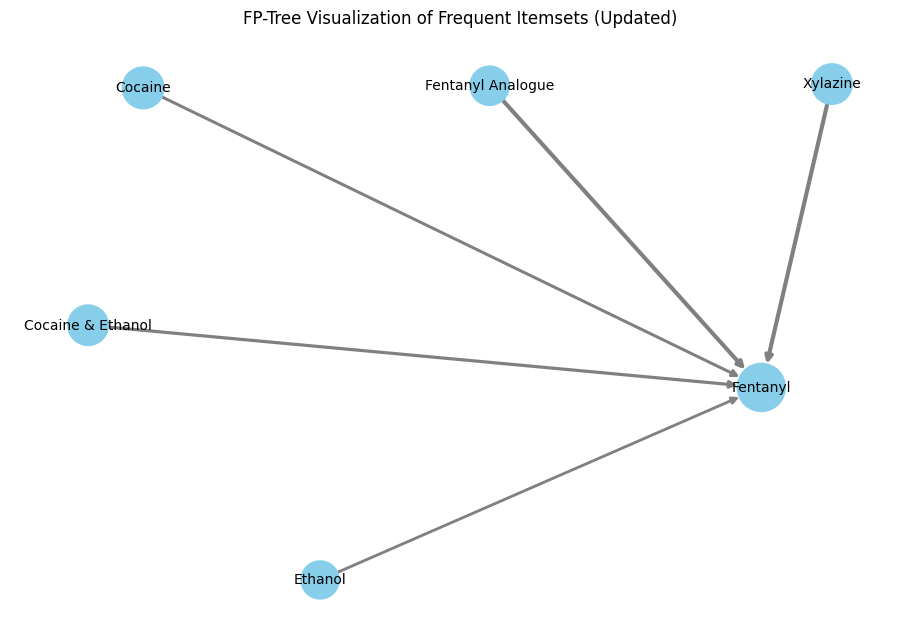

In [ ]:
# Updated associations from FP-Growth results
edges = [
    ("Xylazine", "Fentanyl", 0.996289),
    ("Fentanyl Analogue", "Fentanyl", 0.987680),
    ("Cocaine & Ethanol", "Fentanyl", 0.765324),
    ("Cocaine", "Fentanyl", 0.725644),
    ("Ethanol", "Fentanyl", 0.679375)
]

# Create a directed graph
G = nx.DiGraph()

# Define node sizes (default 500 for missing ones)
node_sizes = {
    "Xylazine": 850, "Fentanyl Analogue": 800, "Cocaine": 900,
    "Ethanol": 750, "Cocaine & Ethanol": 850, "Fentanyl": 1200
}

# Ensure all nodes are included
for node in set([source for source, _, _ in edges] + [target for _, target, _ in edges]):
    if node not in node_sizes:
        node_sizes[node] = 500  # Default size
    G.add_node(node, size=node_sizes[node])

# Add edges with weights (confidence)
for source, target, weight in edges:
    G.add_edge(source, target, weight=weight)

# Draw the graph
plt.figure(figsize=(9, 6))
pos = nx.spring_layout(G, seed=42)  # Adjust layout for better spacing
edges_weights = [G[u][v]['weight'] * 3 for u, v in G.edges()]  # Scale edge thickness

nx.draw(
    G, pos, with_labels=True, node_size=[G.nodes[n]['size'] for n in G.nodes()],
    node_color="skyblue", edge_color="gray", width=edges_weights, font_size=10
)

plt.title("FP-Tree Visualization of Frequent Itemsets (Updated)")
plt.show()

# **Model Comparison and Summary of Observations**

In [ ]:
# Measure execution time for Apriori algorithm
start_time = time.time()
apriori_results = apriori(df_encoded, min_support=min_support, use_colnames=True)
apriori_time = time.time() - start_time

# Measure execution time for FP-Growth algorithm
start_time = time.time()
fpgrowth_results = fpgrowth(df_encoded, min_support=min_support, use_colnames=True)
fpgrowth_time = time.time() - start_time

# Compare algorithm performance
print("\nAlgorithm Performance Comparison:")
print(f"Apriori Execution Time: {apriori_time:.4f} seconds")
print(f"FP-Growth Execution Time: {fpgrowth_time:.4f} seconds")

# Compare number of frequent itemsets discovered
print("\nNumber of Frequent Itemsets Discovered:")
print(f"Apriori: {len(apriori_results)} itemsets")
print(f"FP-Growth: {len(fpgrowth_results)} itemsets")

# Display the top 5 association rules based on lift for Apriori
print("\nTop 5 Rules from Apriori:")
print(rules_apriori[['antecedents', 'consequents', 'support', 'confidence', 'lift']].nlargest(5, 'lift'))

# Display the top 5 association rules based on lift for FP-Growth
print("\nTop 5 Rules from FP-Growth:")
print(rules_fpgrowth[['antecedents', 'consequents', 'support', 'confidence', 'lift']].nlargest(5, 'lift'))


Algorithm Performance Comparison:
Apriori Execution Time: 0.0103 seconds
FP-Growth Execution Time: 0.8560 seconds

Number of Frequent Itemsets Discovered:
Apriori: 23 itemsets
FP-Growth: 23 itemsets

Top 5 Rules from Apriori:
           antecedents consequents   support  confidence      lift
3           (Xylazine)  (Fentanyl)  0.089642    0.996289  1.483353
2  (Fentanyl Analogue)  (Fentanyl)  0.080294    0.987680  1.470534
4   (Cocaine, Ethanol)  (Fentanyl)  0.072949    0.765324  1.139474
0            (Cocaine)  (Fentanyl)  0.277272    0.725644  1.080396
1            (Ethanol)  (Fentanyl)  0.181454    0.679375  1.011506

Top 5 Rules from FP-Growth:
           antecedents consequents   support  confidence      lift
4           (Xylazine)  (Fentanyl)  0.089642    0.996289  1.483353
5  (Fentanyl Analogue)  (Fentanyl)  0.080294    0.987680  1.470534
3   (Cocaine, Ethanol)  (Fentanyl)  0.072949    0.765324  1.139474
0            (Cocaine)  (Fentanyl)  0.277272    0.725644  1.080396
2      